Processing 43 files...

Best Layer identified for each model:
                     Model Layer  Accuracy
0      Falcon3-7B-Instruct    13      0.02
3    Llama-3.1-8B-Instruct    15      0.14
6   Llama-3.3-70B-Instruct    39      0.22
9      Qwen2.5-7B-Instruct    13      0.00
12           gemma-2-9b-it    20      0.02


/tmp/ipykernel_3423640/2057568063.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Model_Label'] = df_filtered.apply(


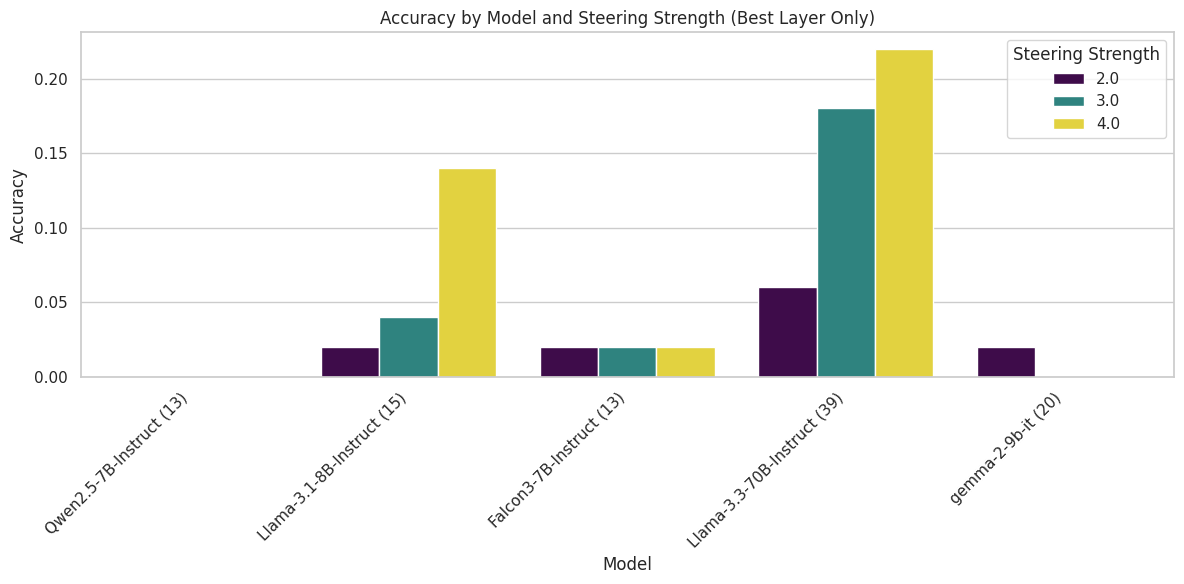

In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def process_and_plot():
    data = []
    # List all json files in the current directory
    data_dir = '../data/results/thought_injection'
    files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
    
    if not files:
        print("No JSON files found in the current directory.")
        return

    print(f"Processing {len(files)} files...")

    for filename in files:
        try:
            # Expected format: model_id_target_layer_steering_strength.json
            # We split from the right to handle model_ids containing underscores
            name_no_ext = filename[:-5] # remove .json
            parts = name_no_ext.split('_')
            
            if len(parts) != 4:
                print(f"Skipping {filename}: Does not match naming convention.")
                continue
                
            _, model_id, layer, strength = parts
            
            file_path = os.path.join(data_dir, filename)
            with open(file_path, 'r') as f:
                content = json.load(f)
                # navigate to _metrics -> accuracy
                metrics = content.get('_metrics', {})
                accuracy = metrics.get('accuracy')
                
            if accuracy is not None:
                data.append({
                    'Model': model_id,
                    'Layer': layer,
                    'Strength': strength,
                    'Accuracy': float(accuracy)
                })
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not data:
        print("No valid data extracted.")
        return

    df = pd.DataFrame(data)
    
    # Convert Strength to numeric for proper sorting in the plot
    df['Strength'] = pd.to_numeric(df['Strength'])
    df = df.sort_values('Strength')

    # --- Filter Logic ---
    # 1. Find the max accuracy achieved for each (Model, Layer) pair
    layer_max = df.groupby(['Model', 'Layer'])['Accuracy'].max().reset_index()
    
    # 2. For each Model, identify the Layer with the absolute highest accuracy
    #    idxmax() gives the index of the max value
    best_layers_idx = layer_max.groupby('Model')['Accuracy'].idxmax()
    best_layers = layer_max.loc[best_layers_idx]
    
    print("\nBest Layer identified for each model:")
    print(best_layers[['Model', 'Layer', 'Accuracy']])

    # 3. Filter the original data to keep only rows belonging to these best layers
    #    Create a set of valid (Model, Layer) tuples
    valid_combinations = set(zip(best_layers['Model'], best_layers['Layer']))
    
    df_filtered = df[df.apply(lambda x: (x['Model'], x['Layer']) in valid_combinations, axis=1)]

    df_filtered['Model_Label'] = df_filtered.apply(
        lambda row: f"{row['Model']} ({row['Layer']})", axis=1
    )

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    # Create the barplot
    chart = sns.barplot(
        data=df_filtered,
        x='Model_Label',
        y='Accuracy',
        hue='Strength',
        palette='viridis'
    )
    
    plt.title('Accuracy by Model and Steering Strength (Best Layer Only)')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right') # Rotate x labels for readability
    plt.legend(title='Steering Strength')
    plt.tight_layout()
    
    plt.show()

if __name__ == "__main__":
    process_and_plot()